In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples
from scipy.stats import chi2_contingency, probplot
import seaborn as sns
import scipy
import statsmodels.api as sm

In [2]:
data=pd.read_csv("titanic_train.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
data['Pclass'] = data['Pclass'].astype('object') # Pclass is nominal attribute so converting it to object type

In [5]:
data.drop(columns=['PassengerId','Name','Ticket'],inplace=True) # Dropping unnecessary columns

In [6]:
data.isnull().sum() # Handle the missing values in the dataset

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
data.shape

(891, 9)

In [8]:
# 'Cabin' Column has more than 50% null values, So let's drop it
data.drop(columns="Cabin",inplace=True)
# Drop null values from embarked column as its a very small % of total rows
data.dropna(subset=['Embarked'],inplace=True)
data.shape

(889, 8)

In [9]:
#Imputing missing values with the mean age of passengers in each Pclass and Sex group, and then use it to fill in the missing values in the 'Age' column
mean_age = data.groupby(['Pclass','Sex'])['Age'].transform('mean')
data['Age'] = data['Age'].fillna(mean_age)

In [10]:
data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [15]:
# Summary statistics for numerical attributes
summary = []
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

for col in numeric_data.columns:
    dtype = numeric_data[col].dtype
    distinct = numeric_data[col].nunique(dropna=False)
    if pd.api.types.is_numeric_dtype(numeric_data[col]):
        mean = numeric_data[col].mean()
        median = numeric_data[col].median()
        std = numeric_data[col].std()
        rng = numeric_data[col].max() - numeric_data[col].min()
    else:
        mean = median = std = rng = np.nan
    summary.append({
        'Attribute': col,
        'Type': str(dtype),
        'Distinct Values': distinct,
        'Mean': mean,
        'Median': median,
        'Std': std,
        'Range': rng
    })
summary_data_numeric = pd.DataFrame(summary)
display(summary_data_numeric)

,Attribute,Type,Distinct Values,Mean,Median,Std,Range
0,Survived,int64,2,0.382452,0.000000,0.486260,1.0000
1,Age,float64,94,29.268362,26.507589,13.245995,79.5800
2,SibSp,int64,7,0.524184,0.000000,1.103705,8.0000
3,Parch,int64,7,0.382452,0.000000,0.806761,6.0000
4,Fare,float64,247,32.096681,14.454200,49.697504,512.3292


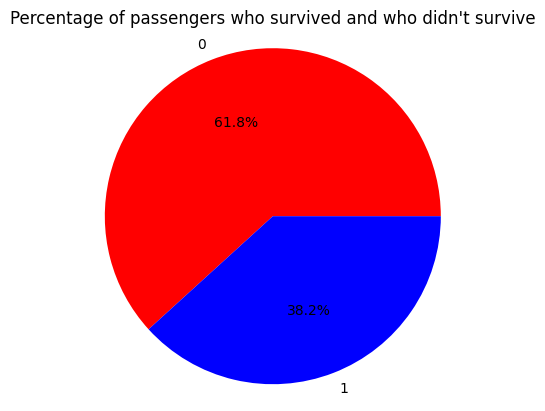

In [17]:
survived_counts = data['Survived'].value_counts()

plt.pie(survived_counts, labels=survived_counts.index, autopct='%1.1f%%', colors=["red","blue"])
plt.title("Percentage of passengers who survived and who didn't survive")
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.show()

In [18]:
Y= data['Survived'] # Taking out survival column for easy analysis.

In [19]:
survival_sex = data.groupby('Sex')['Survived'].mean().reset_index()
display(survival_sex)

survival_pclass = data.groupby('Pclass')['Survived'].mean().reset_index()
display(survival_pclass)

survival_embarked = data.groupby('Embarked')['Survived'].mean().reset_index()
display(survival_embarked)

,Sex,Survived
0,female,0.740385
1,male,0.188908


,Pclass,Survived
0,1,0.626168
1,2,0.472826
2,3,0.242363


,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Survival by Sex: Higher percentage of females survived compared to males. This suggests that gender was a strong factor in survival during the Titanic disaster, likely due to the "women and children first" protocol.

Survival by Pclass: Higher for passengers in higher classes (Pclass 1 and 2) compared to those in the lowest class (Pclass 3).

Survival by Embarked: Some variation in survival rates depending on the port of embarkation, although the difference might not be as pronounced as the difference seen for Sex and Pclass. 

In [21]:
categorical_columns = data.select_dtypes(include=['object'])
categorical_columns.shape

(889, 3)

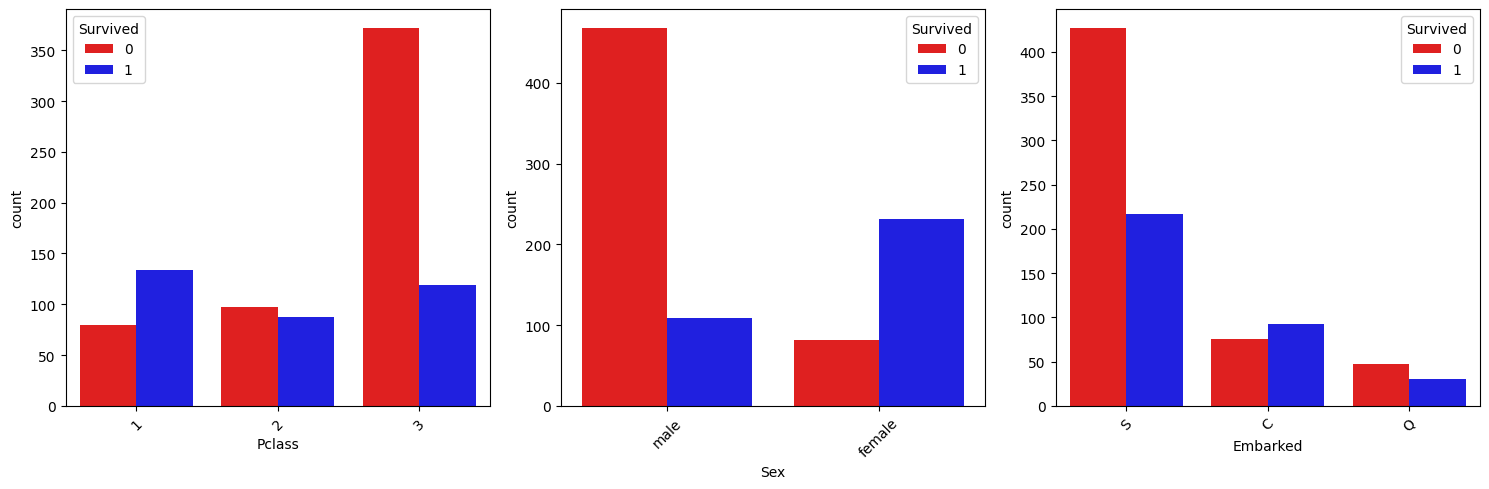

In [25]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_columns.columns, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=data, x=col, hue=Y, palette=["red","blue"])
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

In [26]:
numeric_columns = data.select_dtypes(include=['int64', 'float64'])
numeric_columns.shape

(889, 5)

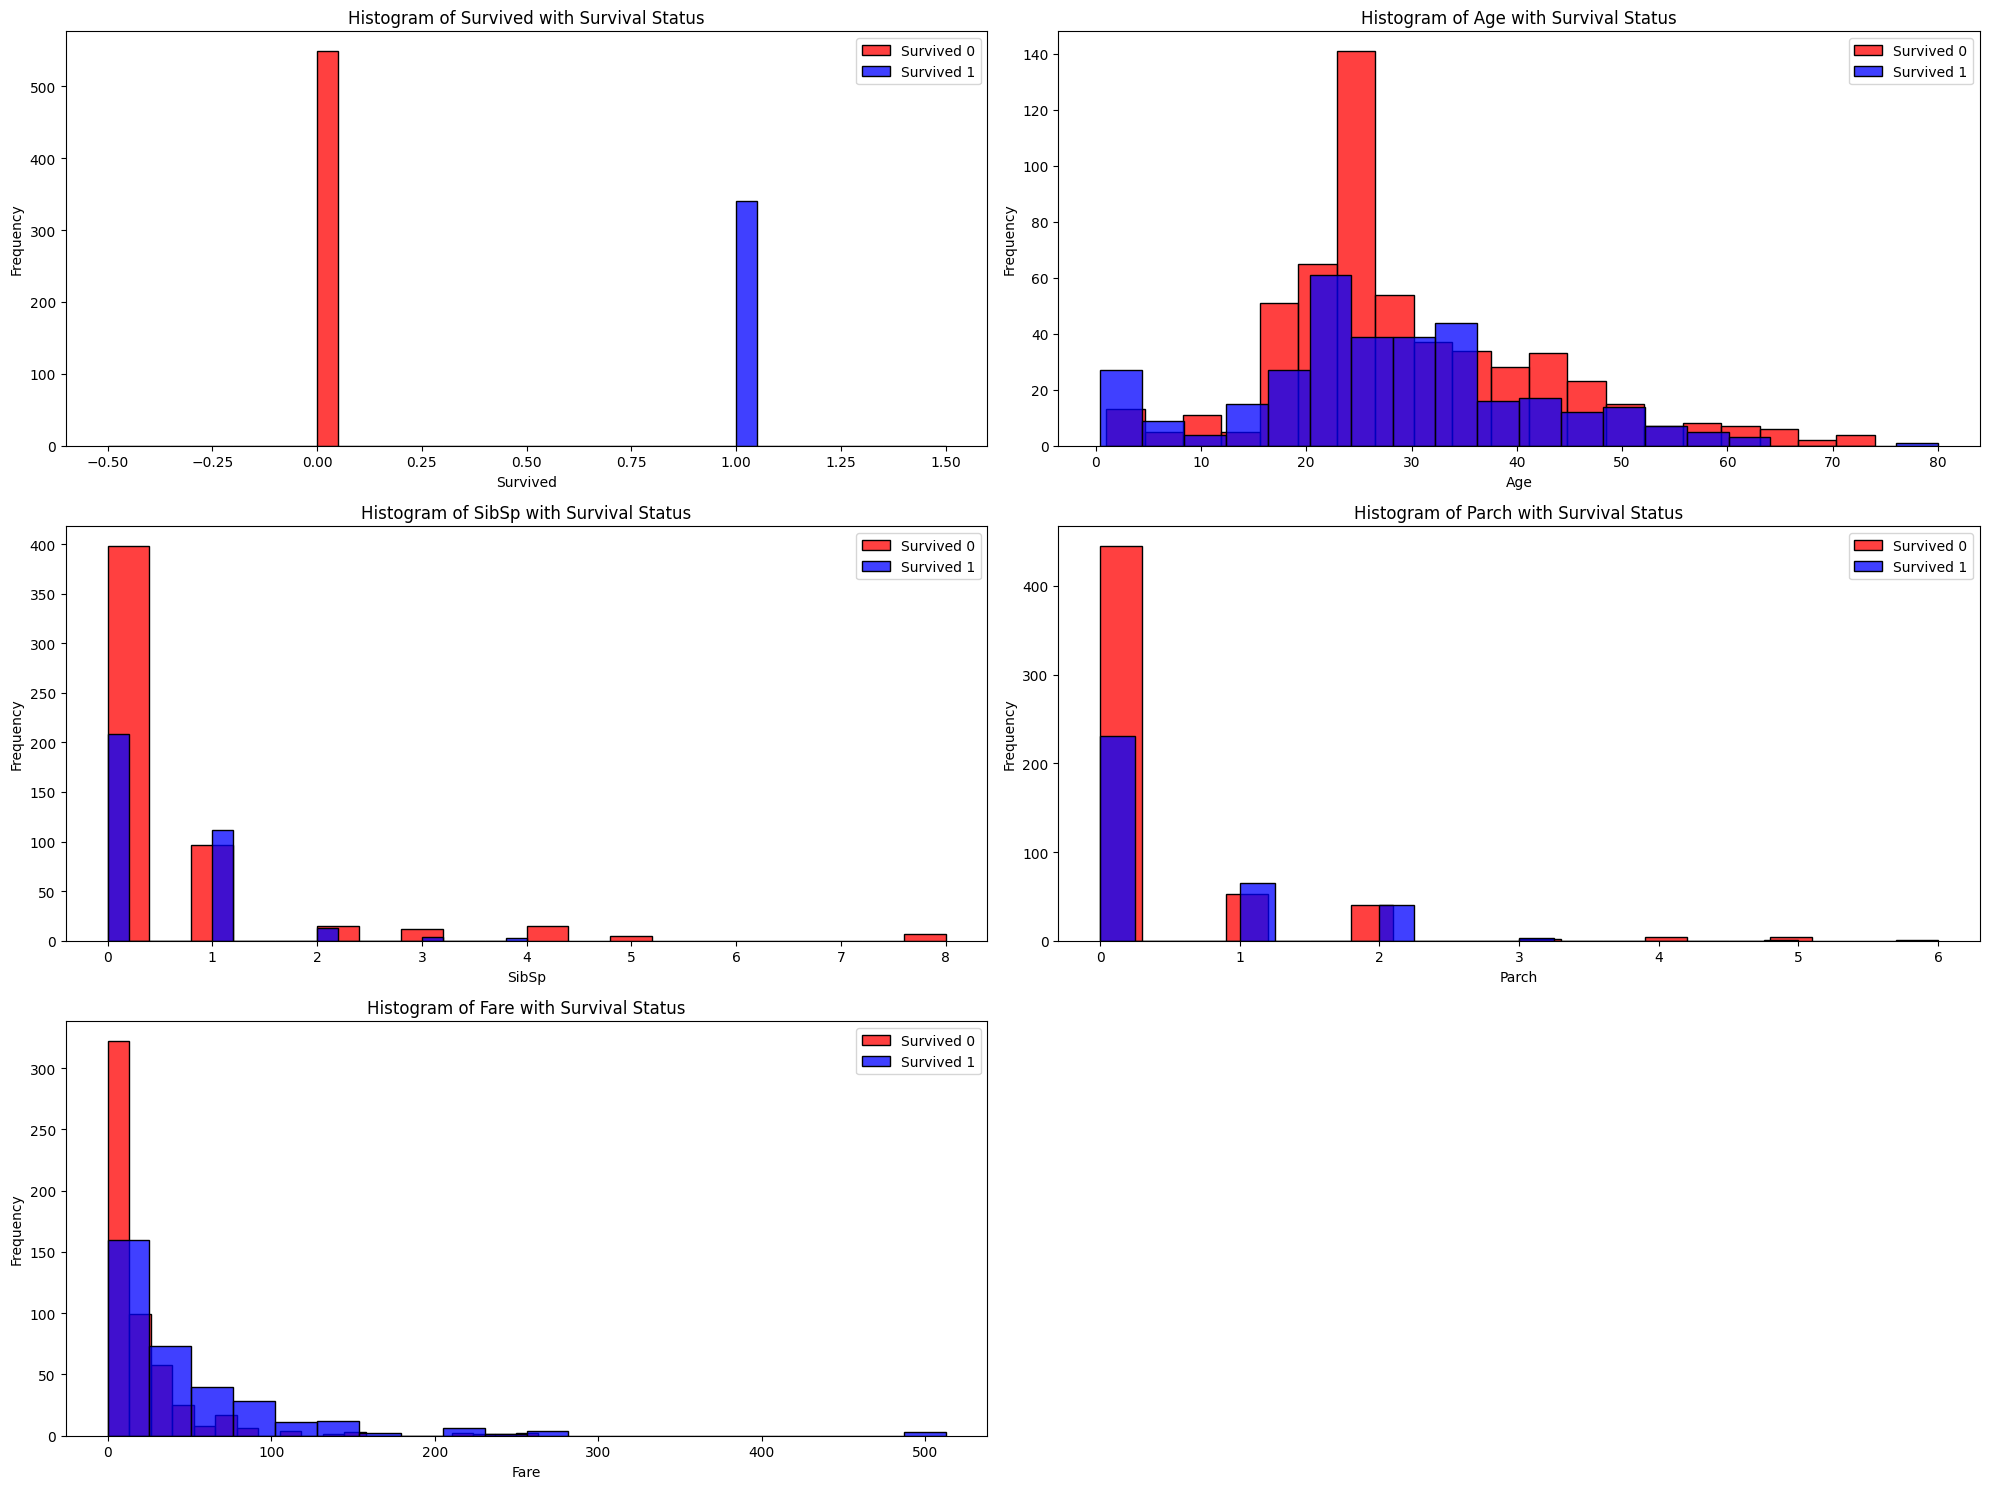

In [28]:
survived_labels = [0, 1]
colors = ['red', 'blue']

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns.columns, 1):
    plt.subplot(3, 2, i)
    for survived_label, color in zip(survived_labels, colors): # Iterate through labels and colors
        sns.histplot(data=data[Y == survived_label], x=col, bins=20,
                     label=f'Survived {survived_label}', kde=False, color=color) # Specify the color
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col} with Survival Status')
    plt.legend()
    plt.tight_layout()

plt.show()

Age: There’s a noticeable “bump” in the very young ages (0–10) for survivors compared to non-survivors, suggesting that children had a higher chance of being saved. The non-survivor curve dominates through much of the adult range (especially 20–40), indicating that prime-age adults were less likely to survive than children or the elderly.

Fare: The right tail of the fare distribution shows a much stronger survivor histogram than non-survivors. This reinforces that passengers paying higher fares—likely first-class or premium cabins—had significantly higher survival rates.

SibSp (Number of Siblings/Spouses aboard): Passengers traveling alone (SibSp = 0) had large counts in both groups, but survivors slightly outnumber non-survivors at SibSp = 0. Very large families (SibSp ≥ 3) appear infrequently overall, with both survival and non-survival counts low.

Parch (Number of Parents/Children aboard): Similar to SibSp, the largest single bar is at Parch = 0 for both groups, but survivors edge out non-survivors here too. Children accompanied by a single guardian were prioritized. Very large Parch counts (≥ 3) are rare and show mixed survival outcomes.

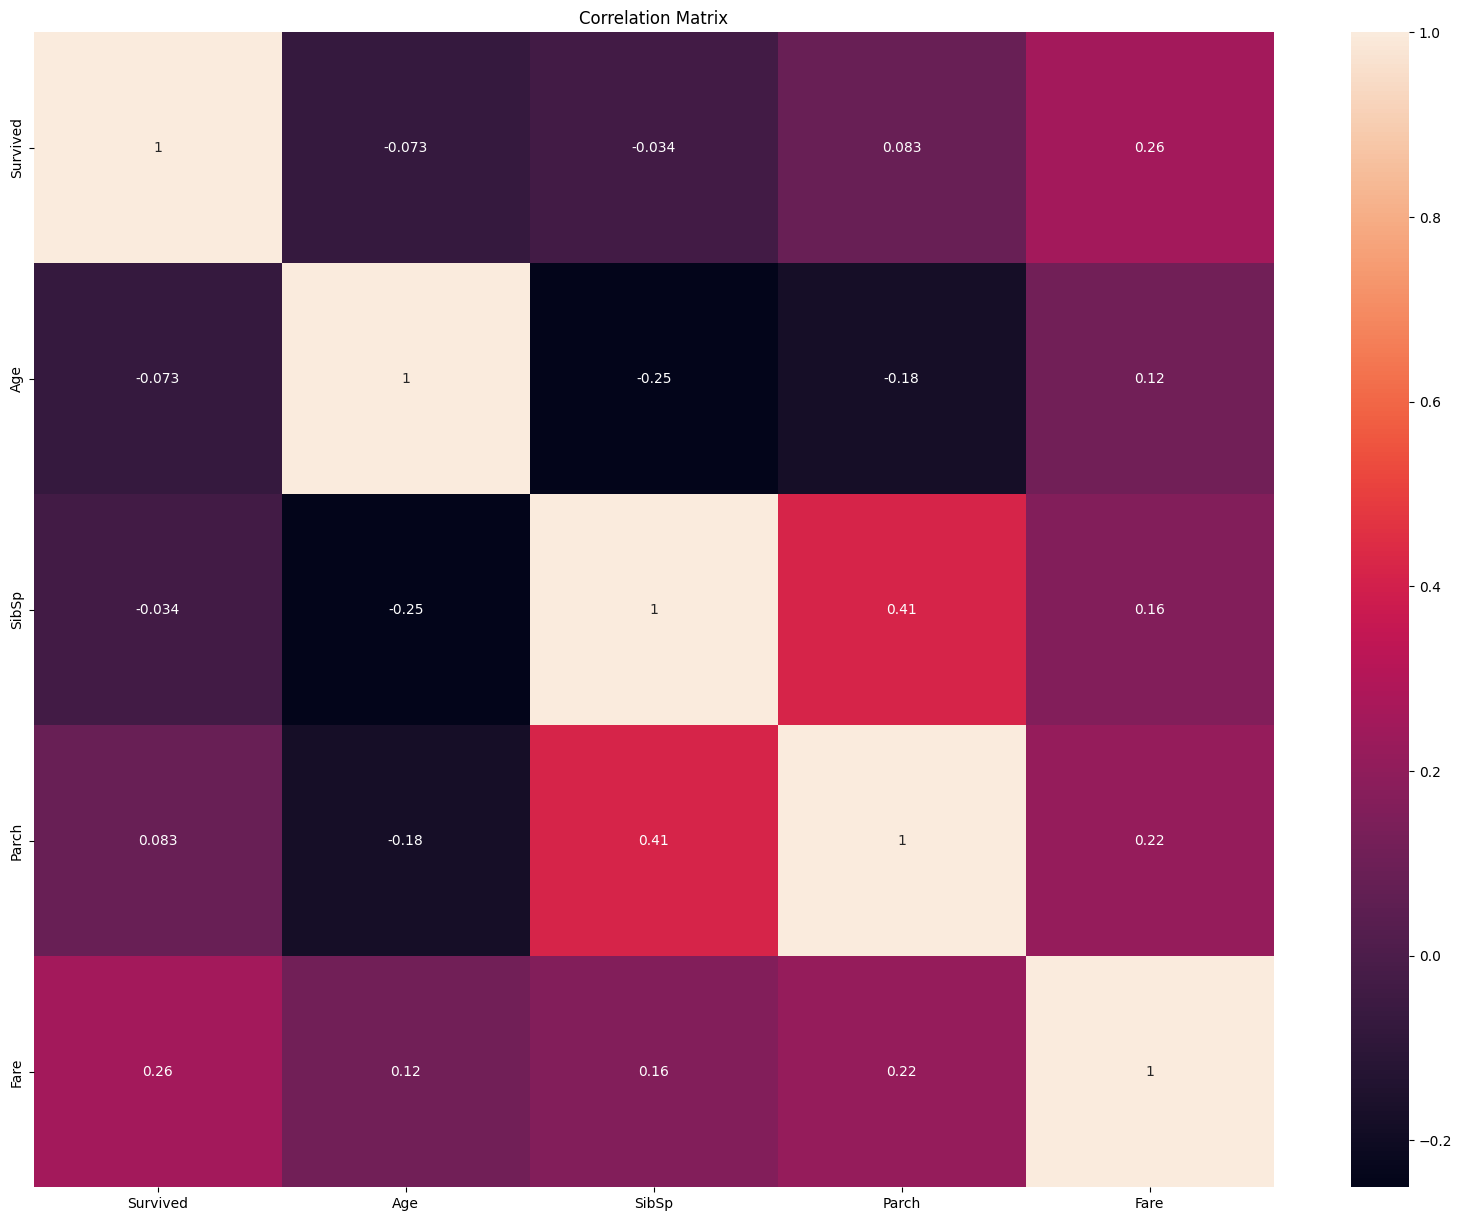

In [29]:
# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

Class and wealth dominate as linear predictors: ticket class and fare share the strongest relationships with survival.

Survived -> SibSp & Parch (–0.04 and –0.02): Family size (siblings/spouses or parents/children aboard) has minimal linear association with survival. 

Survived -> Age (–0.07): A very weak negative correlation, younger passengers tended to survive somewhat more often than older ones—but the link is quite weak in linear terms.

In [41]:
cols_to_test = ['Sex', 'Pclass', 'Embarked']

results = []
for col in cols_to_test:
    contingency = pd.crosstab(data[col], data['Survived'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    results.append({
        'Attribute': col,
        'Chi² Statistic': round(chi2, 2),
        'p-value': p,
        'Significant (p < 0.05)': p < 0.05
    })

chi2_df = pd.DataFrame(results)
display(chi2_df)


,Attribute,Chi² Statistic,p-value,Significant (p < 0.05)
0,Sex,258.43,3.779910e-58,True
1,Pclass,100.98,1.181362e-22,True
2,Embarked,26.49,1.769922e-06,True


Sex is by far the strongest categorical predictor of survival (very large χ², p≪0.001).

Passenger class also shows a highly significant association, 1st class passengers were much likelier to survive.

Port of embarkation remains significant but with a smaller χ², indicating a weaker effect.

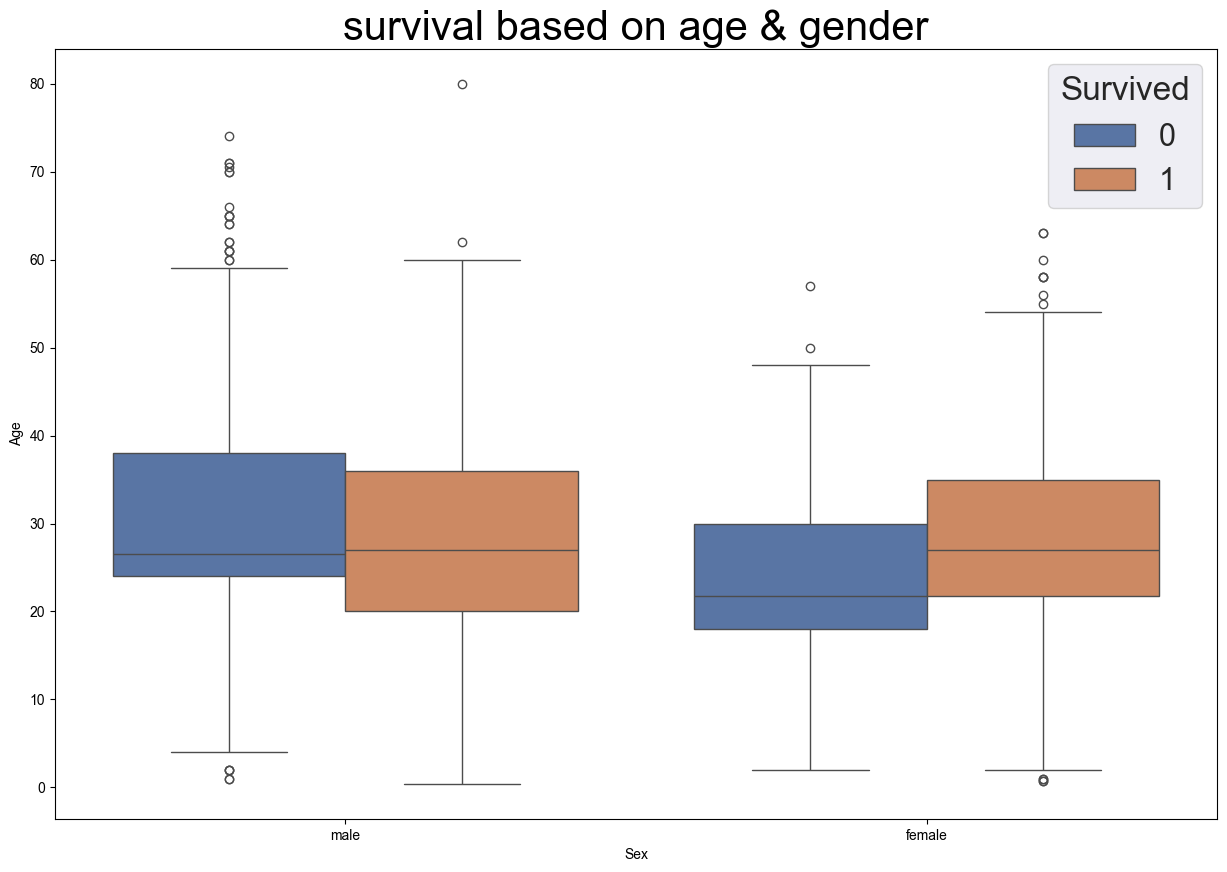

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set(font_scale=2)
sns.boxplot(data=data,x="Sex",y="Age",hue=Y)
plt.title("survival based on age & gender",fontsize=30)
plt.show()

Women of nearly any age had much better odds than men particularly notable in the wider age range of female survivors.

Survival for men was heavily skewed toward youth, indicating that only younger males were prioritized or able to get to lifeboats.

Children (both sexes) fared best of all, “women and children first”, showing that age was the dominant factor for males.

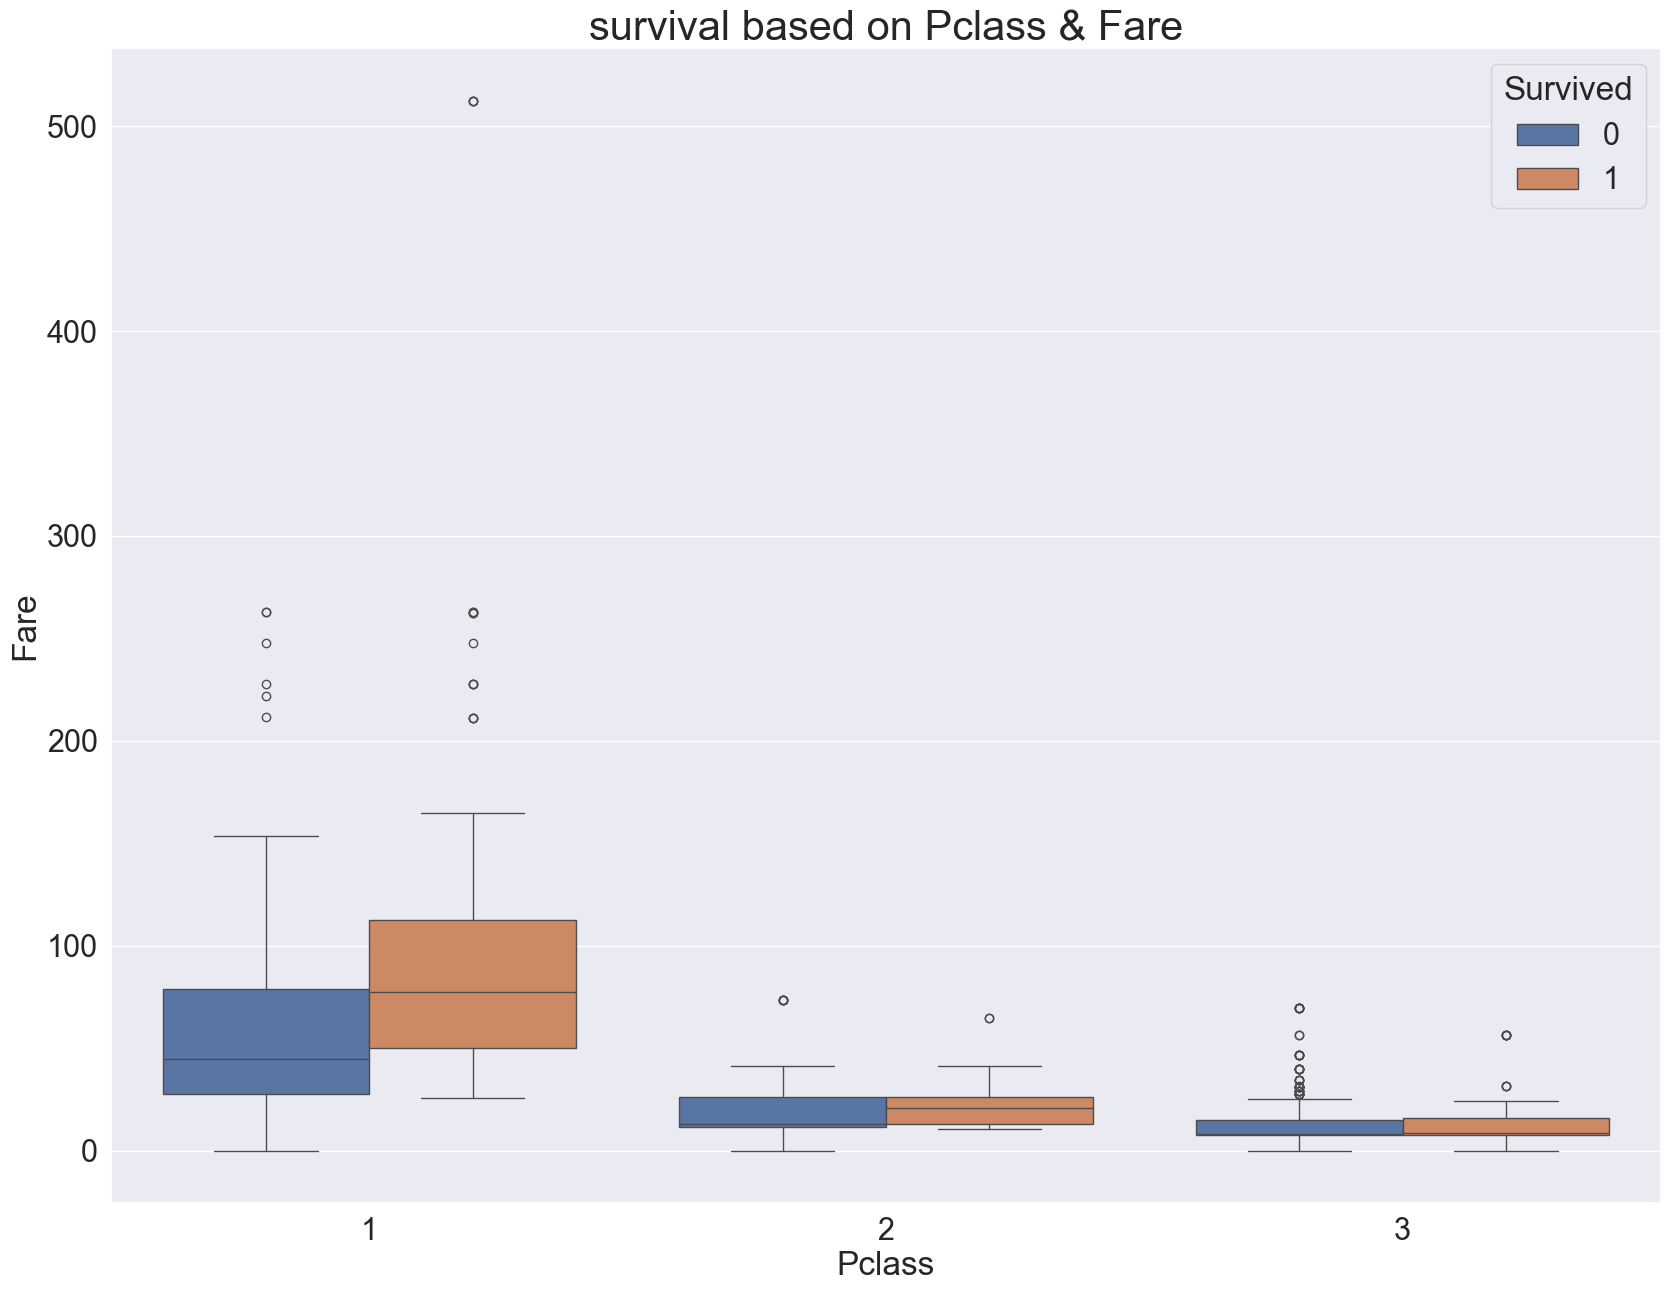

In [31]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=2)
sns.boxplot(data=data,x="Pclass",y="Fare",hue=Y)
plt.title("survival based on Pclass & Fare",fontsize=30)
plt.show()

Pclass remains a strong coarse predictor (first-class ≫ second-class ≫ third-class).

Fare adds extra granularity: passengers who paid more within their class bracket had measurably higher survival rates.

<Figure size 1000x600 with 0 Axes>

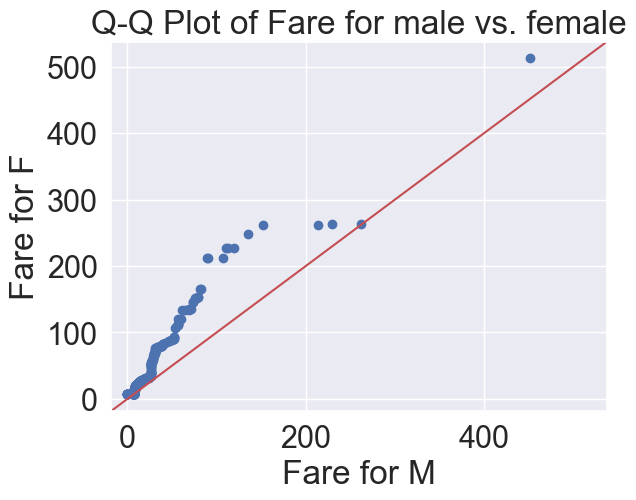

In [37]:
# Define male and female subsets
male_customers = data[data['Sex'] == 'male']
female_customers = data[data['Sex'] == 'female']
plt.figure(figsize=(10, 6))
sm.qqplot_2samples(np.sort(male_customers['Fare']), np.sort(female_customers['Fare']),
                   line='45', xlabel='Fare for M', ylabel='Fare for F')
plt.title('Q-Q Plot of Fare for male vs. female')
plt.show()

The Q–Q plot shows that male and female fare distributions largely match at lower and middle quantiles, indicating similar ticket costs for most passengers of both genders.

However, the female fares deviate above the 45° line in the upper tail, revealing that a subset of women paid significantly higher fares than men.

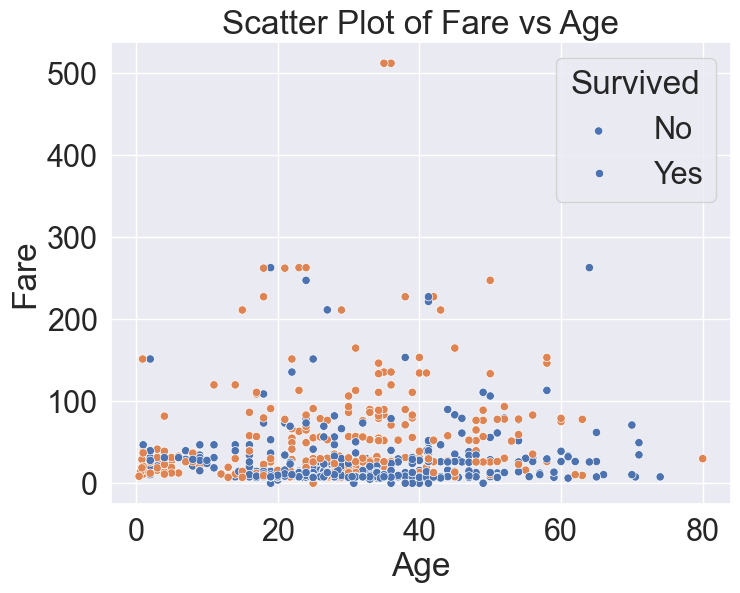

In [35]:
plt.figure(figsize=(18, 6))
sns.scatterplot(data=data, x='Age', y='Fare', hue=Y)
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Scatter Plot of Fare vs Age')
plt.legend(title='Survived', loc='upper right', labels=['No', 'Yes'])
plt.show()

Survivors concentrate in the upper-fare region across nearly all ages, showing that paying more and hence higher class dominated survival odds regardless of age.

Younger passengers (< 20 yrs) appear in both high and low-fare survivor clusters, reinforcing that children benefited from “women and children first” even in cheaper cabins, whereas older low-fare passengers almost universally did not survive.

### Conclusions
Gender Dominance: Women had markedly higher survival rates than men, confirming the strong “women and children first” effect.

Class & Wealth Advantage: First-class passengers and those paying higher fares within each class enjoyed significantly better survival odds.

Child Priority: Children (especially under 10) showed a clear survival bump across sexes and classes, underscoring age-based evacuation priorities.

Nonlinear Age Impact: While overall age correlation with survival was weak, very young and very old passengers experienced distinct survival outcomes not captured by linear metrics.

Secondary Factors: Embarkation port and family size influenced survival in subtler ways C-boarded and small-group travelers fared slightly better but these effects were minor compared to gender, class, and age.